In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.metrics import AUC

2024-05-15 18:28:43.275880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 18:28:43.275991: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 18:28:43.406990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [35]:
IMG_SIZE = 512
IMG_SIZEH = 256
BATCH_SIZE = 16
IMG_CHANNELS = 3

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def square_img(image_path):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Get image dimensions
    height, width = image.shape

    # Determine the size of the square image
    max_dim = max(height, width)
    
    # Create a black square image with dimensions equal to the maximum dimension
    square_image = np.zeros((max_dim, max_dim), dtype=np.uint8)

    # Calculate the position to paste the original image in the square image
    x_offset = (max_dim - width) // 2
    y_offset = (max_dim - height) // 2

    # Paste the original image into the square image
    square_image[y_offset:y_offset+height, x_offset:x_offset+width] = image
    image_shape = square_image.shape
    
    
    return square_image, image_shape

def process_image(image_path):

    # Threshold the image to obtain binary image
    square_image, image_shape = square_img(image_path)
    
    #square_image = cv2.cvtColor(square_image, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(square_image, 240, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    x, y, radius = 0, 0, 0  # Default values
    
    # Iterate through the contours
    for contour in contours:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        
        # Draw the circle
        x = int(x)
        y = int(y)
        radius = int(radius)
   
    return x,y,radius

In [5]:
import os
import cv2
import random

def copy_and_process_images(source_directory, destination_path, Severity):
    """
    Copies images from source directory to destination directory based on specified conditions.
    
    Args:
    - source_directory (str): Path to the source directory containing images.
    - destination_path (str): Path to the destination directory where images will be copied.
    
    Returns:
    - flipped_images (list): List of dictionaries containing information about copied images.
    """
    options = [1, 2]
    
    # Create the destination folder if it doesn't exist
    os.makedirs(destination_path, exist_ok=True)
    
    
    
    flipped_images = []
    
    # Iterate through each folder in the source directory
    for root, dirs, files in os.walk(source_directory):
        
        if source_directory[-6:] == "Normal":
            chosen_option = random.choice(options)
            if chosen_option == 1:
                substring3 = substring1 = 'LEFT_MLO.jpg'
            else:
                substring3 = substring1 = 'RIGHT_MLO.jpg'
        else:
            # Define the substrings you are looking for in the file names
            substring1 = 'LEFT_CC_Mask.jpg'
            substring2 = 'RIGHT_CC_Mask.jpg'
            substring3 = 'LEFT_CC.jpg'
            substring4 = 'RIGHT_CC.jpg'
            
            
            
        # Check if the folder contains a file with substring1
        if any(substring1 in file for file in files):
            if source_directory[-6:] == "Normal":
                X = Y = R = 0
            else:
                file_with_substring1 = next(os.path.join(root, file) for file in files if substring1 in file)
                X, Y, R = process_image(file_with_substring1)  # Assuming you have a function named process_image
            # Find the file with substring3 and copy it
            for file in files:
                if substring3 in file:
                    # Create the source file path
                    source_file_path = os.path.join(root, file)
                    # Process the image and get the processed image
                    processed_image, image_shape = square_img(source_file_path)  # Assuming you have a function named square_img
                    # Create the destination file path
                    destination_file_path = os.path.join(destination_path, file)
                    # Save the processed image
                    cv2.imwrite(destination_file_path, processed_image)
                    flipped_images.append({
                        'REFNUM': destination_file_path,
                        'SEVERITY': Severity,
                        'X': X,
                        'Y': Y,
                        'RADIUS': R,
                        'Image Shape': image_shape[0]
                    })
#                     print(f"File '{file}' copied successfully.")
        
        # Check if the folder contains a file with substring2
        elif any(substring2 in file for file in files):
            if source_directory[-6:] == "Normal":
                X = Y = R = 0
            else:
                file_with_substring2 = next(os.path.join(root, file) for file in files if substring2 in file)
                X, Y, R = process_image(file_with_substring2)  # Assuming you have a function named process_image
            # Find the file with substring4 and copy it
            for file in files:
                if substring4 in file:
                    # Create the source file path
                    source_file_path = os.path.join(root, file)
                    # Process the image and get the processed image
                    processed_image, image_shape = square_img(source_file_path)  # Assuming you have a function named square_img
                    # Create the destination file path
                    destination_file_path = os.path.join(destination_path, file)
                    # Save the processed image
                    cv2.imwrite(destination_file_path, processed_image)
                    flipped_images.append({
                        'REFNUM': destination_file_path,
                        'SEVERITY': Severity,
                        'X': X,
                        'Y': Y,
                        'RADIUS': R,
                        'Image Shape': image_shape[0]
                    })
#                     print(f"File '{file}' copied successfully.")
    
    print("Files copied according to the specified conditions.")
    return flipped_images


In [6]:
import pandas as pd
source_directory_B = '/kaggle/input/miniddsm2/MINI-DDSM-Complete-JPEG-8/Benign'
destination_path_B = "/kaggle/working/benign/"

source_directory_C = '/kaggle/input/miniddsm2/MINI-DDSM-Complete-JPEG-8/Cancer'
destination_path_C = "/kaggle/working/cancer/"

source_directory_N = '/kaggle/input/miniddsm2/MINI-DDSM-Complete-JPEG-8/Normal'
destination_path_N = "/kaggle/working/normal/"

images_DFB = pd.DataFrame(copy_and_process_images(source_directory_B, destination_path_B, "B"))
images_DFC = pd.DataFrame(copy_and_process_images(source_directory_C, destination_path_C, "M"))
images_DFN = pd.DataFrame(copy_and_process_images(source_directory_N, destination_path_N, "N"))

Files copied according to the specified conditions.
Files copied according to the specified conditions.
Files copied according to the specified conditions.


In [7]:
print(len(images_DFB))
print(len(images_DFC))
print(len(images_DFN))

651
644
602


In [8]:
data2 = pd.concat([images_DFB, images_DFC, images_DFN])
data2 = data2.sample(frac=1).reset_index(drop = True)
data2

,REFNUM,SEVERITY,X,Y,RADIUS,Image Shape
0,/kaggle/working/cancer/C_0106_1.LEFT_CC.jpg,M,1042,1935,136,2976
1,/kaggle/working/normal/A_0352_1.RIGHT_MLO.jpg,N,0,0,0,2738
2,/kaggle/working/benign/C_0320_1.LEFT_CC.jpg,B,837,905,85,2212
3,/kaggle/working/cancer/B_3042_1.LEFT_CC.jpg,M,878,825,128,2388
4,/kaggle/working/benign/D_4045_1.LEFT_CC.jpg,B,1121,729,166,2693
...,...,...,...,...,...,...
1892,/kaggle/working/cancer/C_0164_1.LEFT_CC.jpg,M,1264,910,163,2984
1893,/kaggle/working/benign/A_1917_1.RIGHT_CC.jpg,B,1245,1135,42,3421
1894,/kaggle/working/benign/A_1939_1.LEFT_CC.jpg,B,1683,977,161,2671
1895,/kaggle/working/cancer/C_0035_1.RIGHT_CC.jpg,M,1395,755,136,2348


In [9]:
def resize_image(df, new_size = (IMG_SIZE,IMG_SIZE)):
    for index, row in df.iterrows():
        image_path = row['REFNUM']
        image = cv2.imread(image_path)
        resized_image = cv2.resize(image, new_size)
        cv2.imwrite(image_path, resized_image)
resize_image(data2)
data2

,REFNUM,SEVERITY,X,Y,RADIUS,Image Shape
0,/kaggle/working/cancer/C_0106_1.LEFT_CC.jpg,M,1042,1935,136,2976
1,/kaggle/working/normal/A_0352_1.RIGHT_MLO.jpg,N,0,0,0,2738
2,/kaggle/working/benign/C_0320_1.LEFT_CC.jpg,B,837,905,85,2212
3,/kaggle/working/cancer/B_3042_1.LEFT_CC.jpg,M,878,825,128,2388
4,/kaggle/working/benign/D_4045_1.LEFT_CC.jpg,B,1121,729,166,2693
...,...,...,...,...,...,...
1892,/kaggle/working/cancer/C_0164_1.LEFT_CC.jpg,M,1264,910,163,2984
1893,/kaggle/working/benign/A_1917_1.RIGHT_CC.jpg,B,1245,1135,42,3421
1894,/kaggle/working/benign/A_1939_1.LEFT_CC.jpg,B,1683,977,161,2671
1895,/kaggle/working/cancer/C_0035_1.RIGHT_CC.jpg,M,1395,755,136,2348


In [10]:
scaling_factor = IMG_SIZE / data2['Image Shape']
columns_to_scale = ['X', 'Y', 'RADIUS']
data2[columns_to_scale] = data2[columns_to_scale].multiply(scaling_factor, axis=0)

In [11]:
del data2['Image Shape']
data2

,REFNUM,SEVERITY,X,Y,RADIUS
0,/kaggle/working/cancer/C_0106_1.LEFT_CC.jpg,M,179.268817,332.903226,23.397849
1,/kaggle/working/normal/A_0352_1.RIGHT_MLO.jpg,N,0.000000,0.000000,0.000000
2,/kaggle/working/benign/C_0320_1.LEFT_CC.jpg,B,193.735986,209.475588,19.674503
3,/kaggle/working/cancer/B_3042_1.LEFT_CC.jpg,M,188.247906,176.884422,27.443886
4,/kaggle/working/benign/D_4045_1.LEFT_CC.jpg,B,213.127367,138.599332,31.560342
...,...,...,...,...,...
1892,/kaggle/working/cancer/C_0164_1.LEFT_CC.jpg,M,216.879357,156.139410,27.967828
1893,/kaggle/working/benign/A_1917_1.RIGHT_CC.jpg,B,186.331482,169.868460,6.285881
1894,/kaggle/working/benign/A_1939_1.LEFT_CC.jpg,B,322.611756,187.279671,30.861849
1895,/kaggle/working/cancer/C_0035_1.RIGHT_CC.jpg,M,304.190801,164.633731,29.655877


In [12]:
# main_data = pd.concat([data, data2])
main_data = data2

In [13]:
main_data

,REFNUM,SEVERITY,X,Y,RADIUS
0,/kaggle/working/cancer/C_0106_1.LEFT_CC.jpg,M,179.268817,332.903226,23.397849
1,/kaggle/working/normal/A_0352_1.RIGHT_MLO.jpg,N,0.000000,0.000000,0.000000
2,/kaggle/working/benign/C_0320_1.LEFT_CC.jpg,B,193.735986,209.475588,19.674503
3,/kaggle/working/cancer/B_3042_1.LEFT_CC.jpg,M,188.247906,176.884422,27.443886
4,/kaggle/working/benign/D_4045_1.LEFT_CC.jpg,B,213.127367,138.599332,31.560342
...,...,...,...,...,...
1892,/kaggle/working/cancer/C_0164_1.LEFT_CC.jpg,M,216.879357,156.139410,27.967828
1893,/kaggle/working/benign/A_1917_1.RIGHT_CC.jpg,B,186.331482,169.868460,6.285881
1894,/kaggle/working/benign/A_1939_1.LEFT_CC.jpg,B,322.611756,187.279671,30.861849
1895,/kaggle/working/cancer/C_0035_1.RIGHT_CC.jpg,M,304.190801,164.633731,29.655877


In [14]:
from sklearn.utils import shuffle
# Shuffle the rows
main_data = shuffle(main_data).reset_index(drop=True)
columns_to_convert = ['X', 'Y', 'RADIUS'] 
main_data[columns_to_convert] = main_data[columns_to_convert].astype(int)
main_data


,REFNUM,SEVERITY,X,Y,RADIUS
0,/kaggle/working/cancer/B_3503_1.LEFT_CC.jpg,M,156,339,22
1,/kaggle/working/cancer/B_3002_1.LEFT_CC.jpg,M,228,258,26
2,/kaggle/working/normal/A_0130_1.RIGHT_MLO.jpg,N,0,0,0
3,/kaggle/working/cancer/A_1570_1.RIGHT_CC.jpg,M,162,149,31
4,/kaggle/working/benign/C_0305_1.RIGHT_CC.jpg,B,345,262,32
...,...,...,...,...,...
1892,/kaggle/working/benign/C_0308_1.RIGHT_CC.jpg,B,409,174,21
1893,/kaggle/working/cancer/A_1622_1.LEFT_CC.jpg,M,337,320,23
1894,/kaggle/working/benign/A_1862_1.LEFT_CC.jpg,B,239,385,21
1895,/kaggle/working/cancer/C_0114_1.LEFT_CC.jpg,M,132,178,17


In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_images_with_circles_and_labels(dataframe, rows=5, cols=3, image_size=512):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

    for i in range(rows):
        for j in range(cols):
            index = np.random.randint(0, len(dataframe))  # Randomly select an index
            img_path = dataframe.iloc[index, 0]
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
            img = cv2.resize(img, (image_size, image_size))
            x = int(dataframe.iloc[index, 2])
            y = int(dataframe.iloc[index, 3])
            radius = int(dataframe.iloc[index, 4])
            cv2.circle(img, (x, y), radius, (255, 0, 0), 4)  # Draw circle
            axes[i, j].imshow(img, cmap='gray')  # Plot in grayscale
            axes[i, j].axis('off')
            label = dataframe.iloc[index, 1]
            axes[i, j].set_title(f"Severity: {label}", fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [16]:
DFM = main_data[main_data['SEVERITY'] == 'M']
DFB = main_data[main_data['SEVERITY'] == 'B']
DFN = main_data[main_data['SEVERITY'] == 'N']
print(len(DFM))
print(len(DFB))
print(len(DFN))

644
651
602


In [24]:
DFM = DFM[DFM['RADIUS'] >= 35]
DFB = DFB[DFB['RADIUS'] < 19]
DFN = DFN.sample(n=290, random_state=42)
data2 = pd.concat([DFB, DFM, DFN])
print(len(DFM))
print(len(DFN))
print(len(DFB))

287
290
283


In [25]:
import numpy as np
from scipy.ndimage import zoom

def clipped_zoom(img, zoom_factor, **kwargs):

    h, w = img.shape[:2]

    # For multichannel images we don't want to apply the zoom factor to the RGB
    # dimension, so instead we create a tuple of zoom factors, one per array
    # dimension, with 1's for any trailing dimensions after the width and height.
    zoom_tuple = (zoom_factor,) * 2 + (1,) * (img.ndim - 2)

    # Zooming out
    if zoom_factor < 1:

        # Bounding box of the zoomed-out image within the output array
        zh = int(np.round(h * zoom_factor))
        zw = int(np.round(w * zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        # Zero-padding
        out = np.zeros_like(img)
        out[top:top+zh, left:left+zw] = zoom(img, zoom_tuple, **kwargs)

    # Zooming in
    elif zoom_factor > 1:

        # Bounding box of the zoomed-in region within the input array
        zh = int(np.round(h / zoom_factor))
        zw = int(np.round(w / zoom_factor))
        top = (h - zh) // 2
        left = (w - zw) // 2

        out = zoom(img[top:top+zh, left:left+zw], zoom_tuple, **kwargs)

        # `out` might still be slightly larger than `img` due to rounding, so
        # trim off any extra pixels at the edges
        trim_top = ((out.shape[0] - h) // 2)
        trim_left = ((out.shape[1] - w) // 2)
        out = out[trim_top:trim_top+h, trim_left:trim_left+w]

    # If zoom_factor == 1, just return the input array
    else:
        out = img
    return out

In [26]:
import math
import sympy as sp
from scipy.optimize import fsolve
from math import sqrt

def solve_equations(a, b, z):
    z1, z2 = 0, 0
    if z < 1:
        z1 = 0.8
        z2 = 0.2
    else:
        z1 = 1.2
        z2 = 0.2

    p = [a, b]
    q = [(IMG_SIZEH), (IMG_SIZEH)]

    # Calculate Euclidean distance
    dis = math.dist(p, q)

    # Define symbolic variables
    x, y = sp.symbols('x y')

    def equations(vars):
      x, y = vars
      eq1 = sqrt(((IMG_SIZEH) - x)**2 + ((IMG_SIZEH) - y)**2) - z1*dis
      eq2 = sqrt((a - x)**2 + (b - y)**2) - z2*dis
      return [eq1, eq2]

    x, y =  fsolve(equations, (1, 1))

    return x, y

In [27]:
import cv2
import numpy as np

def rotate_image(image, angle_degrees):
    # Get the image dimensions
    height, width = image.shape[:2]

    # Calculate the center point
    center = (width // 2, height // 2)

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D(center, angle_degrees, 1.0)  # 1.0 is the scaling factor (no scaling)

    # Apply the rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))

    return rotated_image

In [28]:
import math

def rotate_point(x, y, center_x, center_y, angle_degrees):
    angle_radians = math.radians(angle_degrees)  # Convert degrees to radians
    new_x = (x - center_x) * math.cos(angle_radians) - (y - center_y) * math.sin(angle_radians) + center_x
    new_y = (x - center_x) * math.sin(angle_radians) + (y - center_y) * math.cos(angle_radians) + center_y
    return new_x, new_y

In [29]:
import numpy as np
import matplotlib.pyplot as plt
speckl = True

def add_gaussian_noise(image, mean=0, sigma=25):
    if not add_gauss:
        return image
    
    else:
        gaussian_noise = np.random.normal(mean, sigma, image.shape)
        noisy_image = np.clip(image + gaussian_noise, 0, 255).astype(np.uint8)
        return image

def add_salt_and_pepper_noise(image, salt_prob=0.02, pepper_prob=0.02):
    noisy_image = np.copy(image)
    salt_pixels = np.random.rand(*image.shape) < salt_prob
    pepper_pixels = np.random.rand(*image.shape) < pepper_prob
    noisy_image[salt_pixels] = 255
    noisy_image[pepper_pixels] = 0
    return image

def add_speckle_noise(image, scale=0.1):
    if not speckl:
        return image
        
    else:
        speckle = np.random.normal(0, scale, image.shape)
        noisy_image = np.clip(image + image * speckle, 0, 255).astype(np.uint8)
        return image

In [30]:
# Add 4 columns with boolean values (all initialized to 0)
data2['ZI'] = 0
data2['ZO+'] = 0
data2['ZO-'] = 0
data2['ZO'] = 0
data2['vert'] = 0
data2['horz'] = 0

# Display the DataFrame after adding new columns
print("\nDataFrame after adding boolean columns:")
print(data2)


DataFrame after adding boolean columns:
                                             REFNUM SEVERITY    X    Y  \
23     /kaggle/working/benign/B_3127_1.RIGHT_CC.jpg        B  313  257   
24      /kaggle/working/benign/A_1868_1.LEFT_CC.jpg        B  372  239   
25     /kaggle/working/benign/A_1773_1.RIGHT_CC.jpg        B  232  402   
28      /kaggle/working/benign/C_0280_1.LEFT_CC.jpg        B  148  130   
53      /kaggle/working/benign/A_1284_1.LEFT_CC.jpg        B  221  344   
...                                             ...      ...  ...  ...   
1229  /kaggle/working/normal/A_0032_1.RIGHT_MLO.jpg        N    0    0   
18    /kaggle/working/normal/D_4607_1.RIGHT_MLO.jpg        N    0    0   
458   /kaggle/working/normal/A_0225_1.RIGHT_MLO.jpg        N    0    0   
1010  /kaggle/working/normal/A_0450_1.RIGHT_MLO.jpg        N    0    0   
1718   /kaggle/working/normal/A_1965_1.LEFT_MLO.jpg        N    0    0   

      RADIUS  ZI  ZO+  ZO-  ZO  vert  horz  
23        10   0    0    

In [31]:
from skimage import io
import numpy as np
def random_choice2():
    choices = ['vert', 'horz']
    return np.random.choice(choices)

def flip_aug(df,limit):
    flipped_images=[]
    count = 0

    while count < limit:
        # Randomly pick a row
        index = np.random.choice(df.index)
        row = df.loc[index]

        if row['vert'] and row['horz'] :
            continue
        else :
            count+=1

        choice = random_choice2()
        while row[choice]:
            choice = random_choice2()

        df.loc[index,choice] = 1
        # Load the original image
        original_image = cv2.imread(row['REFNUM'])

        if choice == 'horz':
            flipped_horizontal = add_speckle_noise(cv2.flip(original_image, 1))
            flipped_horizontal_path = row['REFNUM'][:-4] + "_h.jpg"
            io.imsave(flipped_horizontal_path, flipped_horizontal, check_contrast=False)
        
            if row['X']==0:
                new_x = row['X']
            else:
                new_x = IMG_SIZE - row['X']
            

            flipped_images.append({
                'REFNUM': flipped_horizontal_path,
                'X': new_x,
                'Y': row['Y'],
                'SEVERITY': row['SEVERITY'],
                'RADIUS': row['RADIUS'],
                'ZI': row['ZI'],
                'ZO+': row['ZO+'],
                'ZO': row['ZO'],
                'ZO-': row['ZO-'],
                'vert':row['vert'],
                'horz': 1
            })

        else:  # Default to (Vertical)
        
            flipped_v = add_speckle_noise(cv2.flip(original_image, 0))
            flipped_v_path = row['REFNUM'][:-4] + "_v.jpg"
            io.imsave(flipped_v_path, flipped_v, check_contrast=False)
        
            if row['Y']==0:
                new_y = row['Y']
            else:
                new_y = IMG_SIZE - row['Y']
            

            flipped_images.append({
                'REFNUM': flipped_v_path,
                'X': row['X'],
                'Y': new_y,
                'SEVERITY': row['SEVERITY'],
                'RADIUS': row['RADIUS'],
                'ZI': row['ZI'],
                'ZO+': row['ZO+'],
                'ZO': row['ZO'],
                'ZO-': row['ZO-'],
                'vert':1,
                'horz': row['horz']
            })
    
    flipped_df = pd.DataFrame(flipped_images)
    df = pd.concat([df, flipped_df], ignore_index=True)

    return df


In [32]:
import numpy as np
def random_choice():
    choices = ['ZI', 'ZO+', 'ZO-', 'ZO']
    return np.random.choice(choices)

def aug(df,limit):
    flipped_images=[]
    count = 0

    while count < limit:
        # Randomly pick a row
        index = np.random.choice(df.index)
        row = df.loc[index]

        if row['ZI'] and row['ZO+'] and row['ZO-'] and row['ZO'] :
            continue
        else :
            count+=1

        choice = random_choice()
        while row[choice]:
            choice = random_choice()

        df.loc[index,choice] = 1
        # Load the original image
        original_image = cv2.imread(row['REFNUM'])

        if choice == 'ZO+':
            zmo = clipped_zoom(original_image, 0.8)
            ro1 = add_speckle_noise(rotate_image(zmo, 7))
            ro_path = row['REFNUM'][:-4] + "_zo+.jpg"
            io.imsave(ro_path, ro1, check_contrast=False)
            x1,y1 = solve_equations(row['X'],row['Y'],0.8)
            x1 = int(x1)
            y1 = int(y1)
            x3, y3 = rotate_point(x1, y1, IMG_SIZEH,IMG_SIZEH, -7)
            r1 = int(row['RADIUS']*0.8)

            flipped_images.append({
                'REFNUM': ro_path,
                'X': int(x3),
                'Y': int(y3),
                'SEVERITY': row['SEVERITY'],
                'RADIUS': r1,
                'ZI': row['ZI'],
                'ZO+': 1,
                'ZO': row['ZO'],
                'ZO-': row['ZO-'],
                'vert':row['vert'],
                'horz': row['horz']
              })


        elif choice == 'ZO-':
            zmo = clipped_zoom(original_image, 0.8)
            ro1 = add_speckle_noise(rotate_image(zmo, -7))
            ro_path = row['REFNUM'][:-4] + "_zo-.jpg"
            io.imsave(ro_path, ro1, check_contrast=False)
            x1,y1 = solve_equations(row['X'],row['Y'],0.8)
            x1 = int(x1)
            y1 = int(y1)
            x3, y3 = rotate_point(x1, y1, IMG_SIZEH,IMG_SIZEH, 7)
            r1 = int(row['RADIUS']*0.8)

            flipped_images.append({
                'REFNUM': ro_path,
                'X': int(x3),
                'Y': int(y3),
                'SEVERITY': row['SEVERITY'],
                'RADIUS': r1,
                'ZI': row['ZI'],
                'ZO+': row['ZO+'],
                'ZO': row['ZO'],
                'ZO-': 1,
                'vert':row['vert'],
                'horz': row['horz']
              })

        elif choice == 'ZO':
            zmo = clipped_zoom(original_image, 0.8)
            zo_path = row['REFNUM'][:-4] + "_zo.jpg"
            io.imsave(zo_path, zmo, check_contrast=False)
            x1,y1 = solve_equations(row['X'],row['Y'],0.8)
            x1 = int(x1)
            y1 = int(y1)
            r1 = int(row['RADIUS']*0.8)

            flipped_images.append({
                'REFNUM': zo_path,
                'X': x1,
                'Y': y1,
                'SEVERITY': row['SEVERITY'],
                'RADIUS': r1,
                'ZI': row['ZI'],
                'ZO+': row['ZO+'],
                'ZO': 1,
                'ZO-': row['ZO-'],
                'vert':row['vert'],
                'horz': row['horz']
              })

        else:  # Default to Zoom In (ZI)
            zmo = clipped_zoom(original_image, 1.2)
            zi_path = row['REFNUM'][:-4] + "_zi.jpg"
            io.imsave(zi_path, zmo, check_contrast=False)
            x1,y1 = solve_equations(row['X'],row['Y'],1.2)
            x1 = int(x1)
            y1 = int(y1)
            r1 = int(row['RADIUS']*1.2)

            flipped_images.append({
                'REFNUM': zi_path,
                'X': x1,
                'Y': y1,
                'SEVERITY': row['SEVERITY'],
                'RADIUS': r1,
                'ZI': 1,
                'ZO+': row['ZO+'],
                'ZO': row['ZO'],
                'ZO-': row['ZO-'],
                'vert':row['vert'],
                'horz': row['horz']
              })
    flipped_df = pd.DataFrame(flipped_images)
    df = pd.concat([df, flipped_df], ignore_index=True)

    return df


In [45]:
DFB = data2
DFM = data2
DFN = data2

condition = (data2['SEVERITY'] == "M") | (data2['SEVERITY'] == "N")
DFB = data2[~condition].reset_index(drop=True)

condition = (data2['SEVERITY'] == "B") | (data2['SEVERITY'] == "M")
DFN = data2[~condition].reset_index(drop=True)

condition = (data2['SEVERITY'] == "B") | (data2['SEVERITY'] == "N")
DFM = data2[~condition].reset_index(drop=True)

print(len(DFM))
print(len(DFN))
print(len(DFB))

287
290
283


In [46]:
DFM = flip_aug(DFM,63)
DFM = aug(DFM,50)
print(DFM)

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minp

                                               REFNUM SEVERITY    X    Y  \
0        /kaggle/working/cancer/D_4174_1.RIGHT_CC.jpg        M  377  320   
1         /kaggle/working/cancer/A_1701_1.LEFT_CC.jpg        M  295  169   
2        /kaggle/working/cancer/C_0166_1.RIGHT_CC.jpg        M  364  278   
3         /kaggle/working/cancer/C_0059_1.LEFT_CC.jpg        M  268  234   
4         /kaggle/working/cancer/A_1505_1.LEFT_CC.jpg        M  289  233   
..                                                ...      ...  ...  ...   
395   /kaggle/working/cancer/B_3409_1.LEFT_CC_zo+.jpg        M  191  280   
396   /kaggle/working/cancer/C_0206_1.LEFT_CC_zo-.jpg        M  296  252   
397  /kaggle/working/cancer/A_1896_1.RIGHT_CC_zo-.jpg        M  210  219   
398   /kaggle/working/cancer/D_4177_1.RIGHT_CC_zo.jpg        M  317  168   
399  /kaggle/working/cancer/C_0222_1.LEFT_CC_v_zo.jpg        M  207  202   

     RADIUS  ZI  ZO+  ZO-  ZO  vert  horz  
0        54   0    0    0   0     0     0  

In [47]:
DFB = flip_aug(DFB,47)
DFB = aug(DFB,70)
print(DFB)

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minp

                                               REFNUM SEVERITY    X    Y  \
0        /kaggle/working/benign/B_3127_1.RIGHT_CC.jpg        B  313  257   
1         /kaggle/working/benign/A_1868_1.LEFT_CC.jpg        B  372  239   
2        /kaggle/working/benign/A_1773_1.RIGHT_CC.jpg        B  232  402   
3         /kaggle/working/benign/C_0280_1.LEFT_CC.jpg        B  148  130   
4         /kaggle/working/benign/A_1284_1.LEFT_CC.jpg        B  221  344   
..                                                ...      ...  ...  ...   
395  /kaggle/working/benign/A_1269_1.RIGHT_CC_zo+.jpg        B  218  250   
396    /kaggle/working/benign/B_3104_1.LEFT_CC_zo.jpg        B  189  179   
397   /kaggle/working/benign/A_1846_1.LEFT_CC_zo-.jpg        B  198  307   
398    /kaggle/working/benign/A_1685_1.LEFT_CC_zo.jpg        B  304  207   
399    /kaggle/working/benign/A_1278_1.LEFT_CC_zo.jpg        B  344  205   

     RADIUS  ZI  ZO+  ZO-  ZO  vert  horz  
0        10   0    0    0   0     0     0  

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [48]:
DFN = flip_aug(DFN,40)
DFN = aug(DFN,70)
print(DFN)

                                                REFNUM SEVERITY   X   Y  \
0        /kaggle/working/normal/A_0031_1.RIGHT_MLO.jpg        N   0   0   
1         /kaggle/working/normal/A_0247_1.LEFT_MLO.jpg        N   0   0   
2         /kaggle/working/normal/A_0275_1.LEFT_MLO.jpg        N   0   0   
3         /kaggle/working/normal/A_0578_1.LEFT_MLO.jpg        N   0   0   
4         /kaggle/working/normal/D_4500_1.LEFT_MLO.jpg        N   0   0   
..                                                 ...      ...  ..  ..   
395    /kaggle/working/normal/D_4544_1.LEFT_MLO_zi.jpg        N -51 -51   
396   /kaggle/working/normal/A_0317_1.RIGHT_MLO_zo.jpg        N  51  51   
397   /kaggle/working/normal/A_1974_1.RIGHT_MLO_zi.jpg        N -51 -51   
398  /kaggle/working/normal/D_4571_1.RIGHT_MLO_zo+.jpg        N  27  77   
399    /kaggle/working/normal/A_1995_1.LEFT_MLO_zo.jpg        N  51  51   

     RADIUS  ZI  ZO+  ZO-  ZO  vert  horz  
0         0   0    0    0   1     0     0  
1         0

In [49]:
print(len(DFM))
print(len(DFN))
print(len(DFB))

DFN['X'] = 0
DFN['Y'] = 0
print(DFN)

400
400
400
                                                REFNUM SEVERITY  X  Y  RADIUS  \
0        /kaggle/working/normal/A_0031_1.RIGHT_MLO.jpg        N  0  0       0   
1         /kaggle/working/normal/A_0247_1.LEFT_MLO.jpg        N  0  0       0   
2         /kaggle/working/normal/A_0275_1.LEFT_MLO.jpg        N  0  0       0   
3         /kaggle/working/normal/A_0578_1.LEFT_MLO.jpg        N  0  0       0   
4         /kaggle/working/normal/D_4500_1.LEFT_MLO.jpg        N  0  0       0   
..                                                 ...      ... .. ..     ...   
395    /kaggle/working/normal/D_4544_1.LEFT_MLO_zi.jpg        N  0  0       0   
396   /kaggle/working/normal/A_0317_1.RIGHT_MLO_zo.jpg        N  0  0       0   
397   /kaggle/working/normal/A_1974_1.RIGHT_MLO_zi.jpg        N  0  0       0   
398  /kaggle/working/normal/D_4571_1.RIGHT_MLO_zo+.jpg        N  0  0       0   
399    /kaggle/working/normal/A_1995_1.LEFT_MLO_zo.jpg        N  0  0       0   

     ZI  ZO+  Z

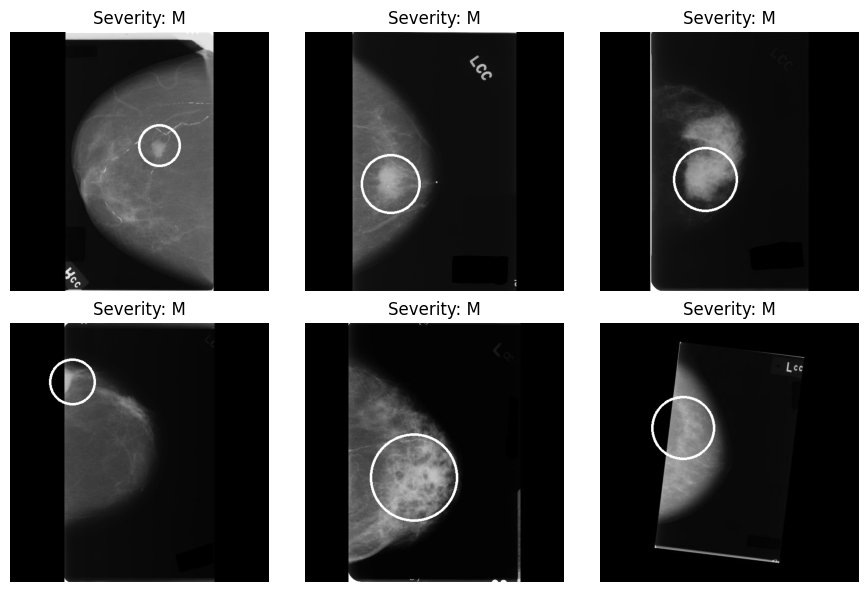

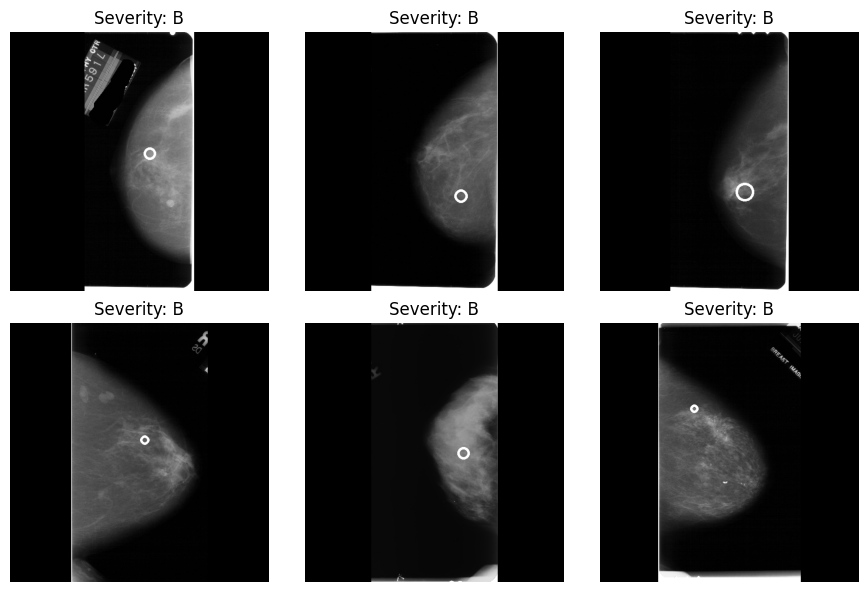

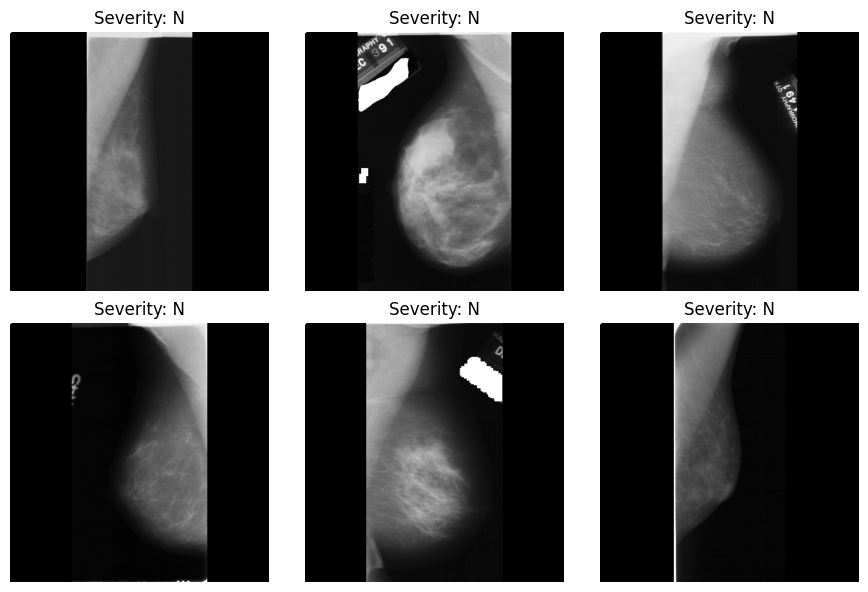

In [50]:
plot_images_with_circles_and_labels(DFM, rows=2, cols=3)
plot_images_with_circles_and_labels(DFB, rows=2, cols=3)
plot_images_with_circles_and_labels(DFN, rows=2, cols=3)

In [51]:
test_split_B = 120
test_split_M = 120
test_split_N = 120
# Shuffle the rows of each DataFrame
DFB_shuffled = shuffle(DFB,random_state=70)
DFM_shuffled = shuffle(DFM,random_state=80)
DFN_shuffled = shuffle(DFN,random_state=90)

In [52]:
dftrain = pd.concat([DFB_shuffled.iloc[test_split_B:], DFM_shuffled.iloc[test_split_M:], DFN_shuffled.iloc[test_split_N:]], ignore_index=True)
dftrain = shuffle(dftrain)
dftest = pd.concat([DFB_shuffled.iloc[test_split_B-10:test_split_B*2-10], DFM_shuffled.iloc[test_split_M:test_split_M * 2 ], DFN_shuffled.iloc[test_split_M-30:test_split_N*2-30]], ignore_index=True)
dftest = shuffle(dftest)
print("Number of rows in dftest:", len(dftest))
print("Number of rows in dftrain:", len(dftrain))

Number of rows in dftest: 360
Number of rows in dftrain: 840


In [53]:
#dftest['SEVERITY'] = dftest['SEVERITY'].replace({'N':0, 'B': 1, 'M': 2})
#dftrain['SEVERITY'] = dftrain['SEVERITY'].replace({'N':0, 'B': 1, 'M': 2})

dftest = dftest.reset_index(drop=True)
dftrain = dftrain.reset_index(drop=True)

In [54]:
dftrain

,REFNUM,SEVERITY,X,Y,RADIUS,ZI,ZO+,ZO-,ZO,vert,horz
0,/kaggle/working/benign/A_1685_1.LEFT_CC_zo.jpg,B,304,207,11,0,0,1,1,0,0
1,/kaggle/working/benign/A_1763_1.LEFT_CC.jpg,B,301,194,14,0,0,0,1,0,0
2,/kaggle/working/normal/A_0364_1.RIGHT_MLO.jpg,N,0,0,0,1,0,0,0,0,0
3,/kaggle/working/cancer/A_1400_1.LEFT_CC_zo.jpg,M,344,291,29,0,0,0,1,0,0
4,/kaggle/working/cancer/C_0091_1.LEFT_CC.jpg,M,117,331,46,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
835,/kaggle/working/benign/A_1755_1.LEFT_CC.jpg,B,318,243,7,0,0,0,0,0,0
836,/kaggle/working/benign/A_1830_1.LEFT_CC.jpg,B,254,181,9,0,0,0,0,0,0
837,/kaggle/working/normal/D_4505_1.RIGHT_MLO_zo+.jpg,N,0,0,0,0,1,0,0,0,0
838,/kaggle/working/cancer/D_4108_1.LEFT_CC.jpg,M,136,303,47,0,0,0,0,1,0


In [55]:
dftest

,REFNUM,SEVERITY,X,Y,RADIUS,ZI,ZO+,ZO-,ZO,vert,horz
0,/kaggle/working/normal/A_2018_1.LEFT_MLO.jpg,N,0,0,0,0,0,0,0,0,0
1,/kaggle/working/benign/A_1275_1.LEFT_CC_zo+.jpg,B,250,211,6,0,1,0,1,0,0
2,/kaggle/working/benign/B_3432_1.RIGHT_CC.jpg,B,334,98,13,0,0,0,0,0,0
3,/kaggle/working/normal/A_0465_1.LEFT_MLO.jpg,N,0,0,0,0,0,0,0,0,0
4,/kaggle/working/benign/A_1914_1.LEFT_CC.jpg,B,308,151,10,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
355,/kaggle/working/normal/D_4549_1.RIGHT_MLO_zi.jpg,N,0,0,0,1,0,0,0,0,0
356,/kaggle/working/normal/A_0427_1.RIGHT_MLO.jpg,N,0,0,0,0,0,0,0,0,0
357,/kaggle/working/cancer/D_4178_1.LEFT_CC.jpg,M,233,233,65,0,0,0,0,1,0
358,/kaggle/working/benign/A_1864_1.LEFT_CC.jpg,B,332,277,4,0,0,0,0,0,0


In [56]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dftrain['severity_encoded'] = label_encoder.fit_transform(dftrain['SEVERITY'])
dftest['severity_encoded'] = label_encoder.fit_transform(dftest['SEVERITY'])
dftrain

,REFNUM,SEVERITY,X,Y,RADIUS,ZI,ZO+,ZO-,ZO,vert,horz,severity_encoded
0,/kaggle/working/benign/A_1685_1.LEFT_CC_zo.jpg,B,304,207,11,0,0,1,1,0,0,0
1,/kaggle/working/benign/A_1763_1.LEFT_CC.jpg,B,301,194,14,0,0,0,1,0,0,0
2,/kaggle/working/normal/A_0364_1.RIGHT_MLO.jpg,N,0,0,0,1,0,0,0,0,0,2
3,/kaggle/working/cancer/A_1400_1.LEFT_CC_zo.jpg,M,344,291,29,0,0,0,1,0,0,1
4,/kaggle/working/cancer/C_0091_1.LEFT_CC.jpg,M,117,331,46,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
835,/kaggle/working/benign/A_1755_1.LEFT_CC.jpg,B,318,243,7,0,0,0,0,0,0,0
836,/kaggle/working/benign/A_1830_1.LEFT_CC.jpg,B,254,181,9,0,0,0,0,0,0,0
837,/kaggle/working/normal/D_4505_1.RIGHT_MLO_zo+.jpg,N,0,0,0,0,1,0,0,0,0,2
838,/kaggle/working/cancer/D_4108_1.LEFT_CC.jpg,M,136,303,47,0,0,0,0,1,0,1


In [57]:
max_x1 = np.max(dftest['X'])
max_x2 = np.max(dftrain['X'])
max_y1 = np.max(dftrain['Y'])
max_y2 = np.max(dftest['Y'])
max_radius1 = np.max(dftest['RADIUS'])
max_radius2 = np.max(dftest['RADIUS'])
numbers = tf.constant([max_x1, max_y1, max_radius1, max_radius2], dtype=tf.float32)
max_scaler = tf.reduce_max(numbers)
max_scaler = np.array(max_scaler)
max_scaler

array(441., dtype=float32)

In [58]:
def preprocess_image(image_path, label, x, y, radius):
    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize pixel values
    x = tf.cast(x, tf.float32) / max_scaler
    y = tf.cast(y, tf.float32) / max_scaler
    radius = tf.cast(radius, tf.float32) / max_scaler
    
    # Return image and labels
    return img, {'classification': tf.one_hot(label, depth = 3),
                 'localization': tf.convert_to_tensor([x, y, radius], dtype=tf.float32)}


In [59]:
# Convert columns to numeric data types
dftrain['X'] = pd.to_numeric(dftrain['X'], errors='coerce')
dftrain['Y'] = pd.to_numeric(dftrain['Y'], errors='coerce')
dftrain['RADIUS'] = pd.to_numeric(dftrain['RADIUS'], errors='coerce')

# Drop rows with NaN values if necessary
dftrain.dropna(subset=['X', 'Y', 'RADIUS'], inplace=True)


dftest['X'] = pd.to_numeric(dftest['X'], errors='coerce')
dftest['Y'] = pd.to_numeric(dftest['Y'], errors='coerce')
dftest['RADIUS'] = pd.to_numeric(dftest['RADIUS'], errors='coerce')

# Drop rows with NaN values if necessary
dftest.dropna(subset=['X', 'Y', 'RADIUS'], inplace=True)

In [60]:
# Create TensorFlow Dataset with image paths and other relevant information
train_dataset = tf.data.Dataset.from_tensor_slices((dftrain['REFNUM'].values,
                                                    dftrain['severity_encoded'].values,
                                                    dftrain['X'].values,
                                                    dftrain['Y'].values,
                                                    dftrain['RADIUS'].values))


# Create TensorFlow Dataset for test data
test_dataset = tf.data.Dataset.from_tensor_slices((dftest['REFNUM'].values,
                                                   dftest['severity_encoded'].values,
                                                   dftest['X'].values,
                                                   dftest['Y'].values,
                                                   dftest['RADIUS'].values))


In [61]:
# Map the preprocessing function to load and preprocess each image
training_dataset = train_dataset.map(lambda image_path, label, x, y, radius:
                                  preprocess_image(image_path, label, x, y, radius),
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
# Map the preprocessing function to load and preprocess each image
test_dataset = test_dataset.map(lambda image_path, label, x, y, radius:
                                preprocess_image(image_path, label, x, y, radius),
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [62]:
train_dataset = training_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [63]:
import matplotlib.pyplot as plt

# Define a function to visualize the dataset
def visualize_dataset(dataset, num_samples=1):
    # Iterate through the dataset and display images with labels
    for image_batch, labels_batch in dataset.take(num_samples):
        for i in range(len(image_batch)):
            img = image_batch[i].numpy()  # Convert TensorFlow tensor to NumPy array
            classification_label = labels_batch['classification'][i].numpy()
            localization_label = labels_batch['localization'][i].numpy()
            
            # Display image
            plt.imshow(img)
            print(np.shape(img))
            plt.axis('off')
            plt.show()
            
            # Print labels
            print("Classification Label:", classification_label)
            print("Localization Label:", localization_label)
            break
        break


(512, 512, 1)


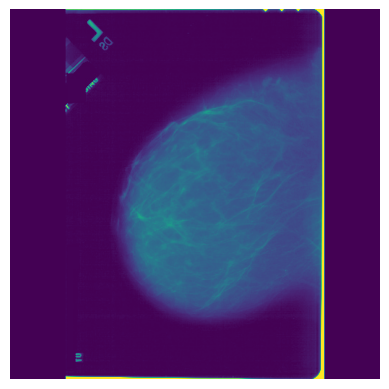

Classification Label: [1. 0. 0.]
Localization Label: [0.5124717  0.6258503  0.02267574]


In [64]:
# Visualize the first few samples from the dataset
visualize_dataset(train_dataset)

(512, 512, 1)


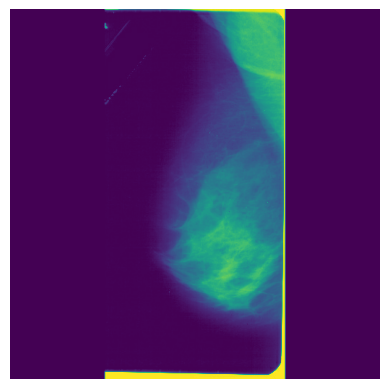

Classification Label: [0. 0. 1.]
Localization Label: [0. 0. 0.]


In [65]:
# Visualize the first few samples from the dataset
visualize_dataset(test_dataset)

In [66]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError, Accuracy

import math
import tensorflow.keras.backend as K


def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

## Input layer
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))



## Feature Extractor
x = tf.keras.layers.Conv2D(16, activation="relu", kernel_size=3,
                             input_shape=(IMG_SIZE, IMG_SIZE, 1))(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(32, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(64, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Conv2D(128, kernel_size=3, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.AveragePooling2D((2,2))(x)
x = tf.keras.layers.Dropout(0.3)(x)






## Dense Layers
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
feature = tf.keras.layers.Dense(64, activation = 'relu')(x)

## Classification head
x = tf.keras.layers.Dense(128, activation = 'relu')(feature)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
classification_output = tf.keras.layers.Dense(3, activation="softmax", name="classification")(x)

## Localization Head
x = tf.keras.layers.Dense(128, activation = 'relu')(feature)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
localization_output = tf.keras.layers.Dense(units=3, activation = 'relu', name="localization")(x)


model = tf.keras.Model(inputs=inputs, outputs=[classification_output, localization_output])


# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'classification': "categorical_crossentropy",
                    'localization': "mse"},
              loss_weights={'classification': 1.0,
                            'localization': 1.0},
              metrics={'classification': ['accuracy', AUC()],
                       'localization': ['mse', r_squared]})
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 510, 510,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 510, 510,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 255, 255,  │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 255, 255,  │          0 │ average_pooling2… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 253, 253,  │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 253, 253,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 126, 126,  │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 126, 126,  │          0 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 124, 124,  │     18,496 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 124, 124,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 62, 62,    │          0 │ batch_normalizat… │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 62, 62,    │          0 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 60, 60,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 30, 30,    │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 28, 28,    │     36,928 │ average_pooling2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_4[0][0]  

 Total params: 1,347,750 (5.14 MB)

 Trainable params: 1,346,886 (5.14 MB)

 Non-trainable params: 864 (3.38 KB)

In [67]:
num_epochs = 300

# Fit the model with the training data
history = model.fit(train_dataset,
                    epochs=num_epochs,
                    validation_data=test_dataset,
                    shuffle = True)

Epoch 1/300


2024-05-15 18:46:26.098440: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5825: 0.647189, expected 0.477991
2024-05-15 18:46:26.098518: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6215: 0.410816, expected 0.241618
2024-05-15 18:46:26.098538: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6725: 0.606545, expected 0.437347
2024-05-15 18:46:26.098559: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7912: 0.595247, expected 0.426048
2024-05-15 18:46:26.098624: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15854: 0.647189, expected 0.477991
2024-05-15 18:46:26.098637: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16246: 0.410816, expected 0.241618
2024-05-15 18:46:26.098654: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16756: 0.606545, expected 0.437347
2024-05-15 18:46:

 3/53 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - classification_accuracy: 0.4757 - classification_auc: 0.5997 - localization_mse: 0.1705 - localization_r_squared: -0.8728 - loss: 1.2707

I0000 00:00:1715798801.530583     209 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715798801.561632     209 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - classification_accuracy: 0.5178 - classification_auc: 0.7131 - localization_mse: 0.0733 - localization_r_squared: 0.1119 - loss: 1.0017

2024-05-15 18:46:50.168665: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.45549, expected 2.6926
2024-05-15 18:46:50.168727: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.19187, expected 2.42899
2024-05-15 18:46:50.168744: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 3.04121, expected 2.27832
2024-05-15 18:46:50.168763: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 3.3637, expected 2.60082
2024-05-15 18:46:50.168776: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.65672, expected 2.89383
2024-05-15 18:46:50.168787: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 4.34674, expected 3.58385
2024-05-15 18:46:50.168799: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 4.38785, expected 3.62496
2024-05-15 18:46:50.168834: E external/local_xla/xla/serv

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - classification_accuracy: 0.5188 - classification_auc: 0.7146 - localization_mse: 0.0728 - localization_r_squared: 0.1175 - loss: 0.9990

W0000 00:00:1715798826.224597     211 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


53/53 ━━━━━━━━━━━━━━━━━━━━ 56s 493ms/step - classification_accuracy: 0.5197 - classification_auc: 0.7159 - localization_mse: 0.0724 - localization_r_squared: 0.1228 - loss: 0.9965 - val_classification_accuracy: 0.3861 - val_classification_auc: 0.5739 - val_localization_mse: 0.0630 - val_localization_r_squared: 0.2020 - val_loss: 1.2388
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - classification_accuracy: 0.6348 - classification_auc: 0.8649 - localization_mse: 0.0272 - localization_r_squared: 0.6588 - loss: 0.6672 - val_classification_accuracy: 0.4444 - val_classification_auc: 0.6544 - val_localization_mse: 0.0542 - val_localization_r_squared: 0.3146 - val_loss: 1.0873
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - classification_accuracy: 0.6973 - classification_auc: 0.8957 - localization_mse: 0.0212 - localization_r_squared: 0.7397 - loss: 0.5924 - val_classification_accuracy: 0.4444 - val_classification_auc: 0.6578 - val_localization_mse: 0.0569 - val_localization_r_s

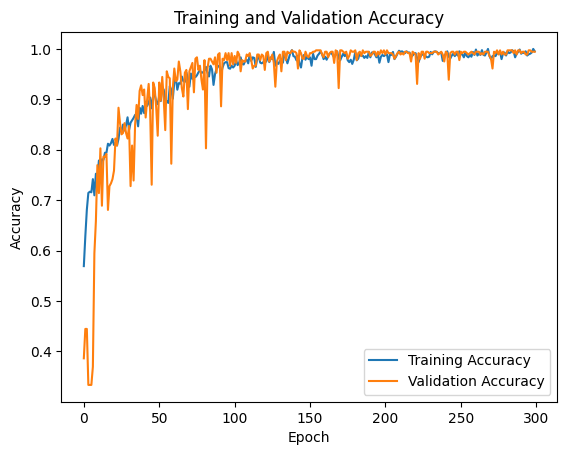

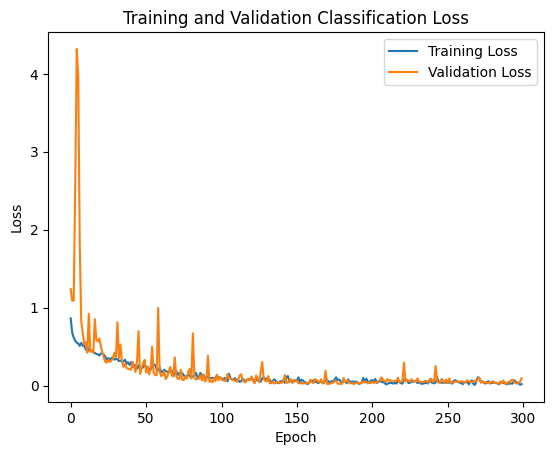

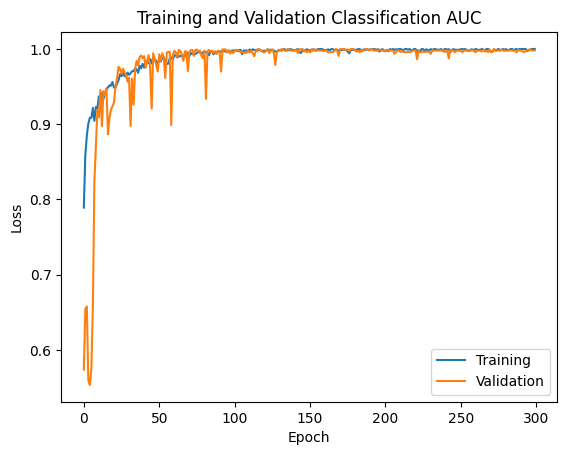

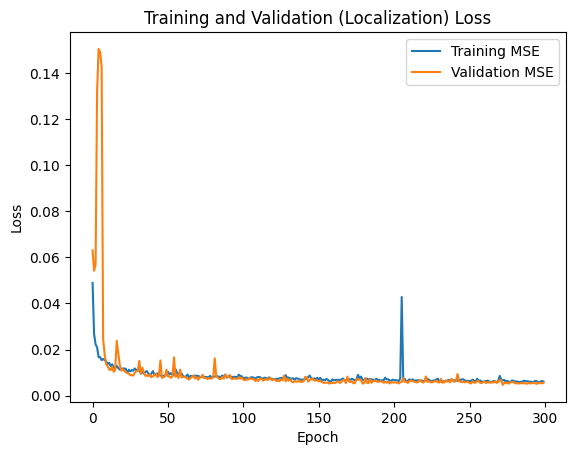

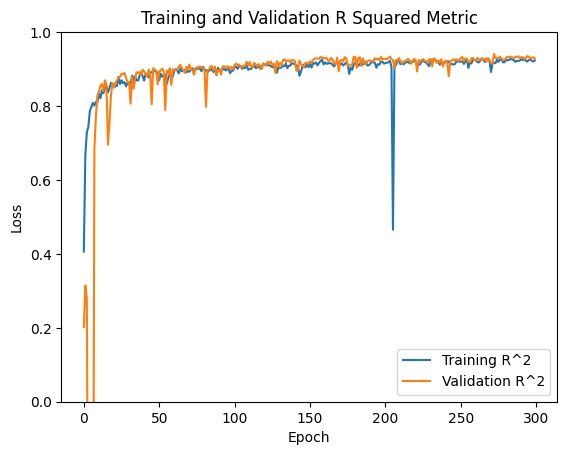

In [68]:

# Plot training and validation accuracy
plt.plot(history.history['classification_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_classification_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation AUC
plt.plot(history.history['classification_auc'], label='Training ')
plt.plot(history.history['val_classification_auc'], label='Validation')
plt.title('Training and Validation Classification AUC')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['localization_mse'], label='Training MSE')
plt.plot(history.history['val_localization_mse'], label='Validation MSE')
plt.title('Training and Validation (Localization) Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation r^2
plt.plot(history.history['localization_r_squared'], label='Training R^2')
plt.plot(history.history['val_localization_r_squared'], label='Validation R^2')
plt.title('Training and Validation R Squared Metric')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.legend()
plt.show()


19/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

W0000 00:00:1715799835.652711     210 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step


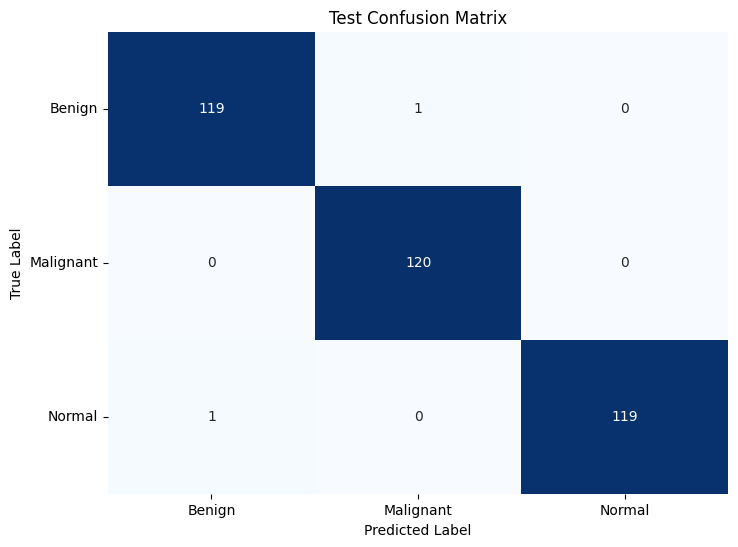

Accuracy: 0.9944444444444445
F1 Score: 0.9944443962182986
Precision: 0.9944674012855831
Recall: 0.9944444444444445


In [69]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score

# Make predictions on the test dataset
predictions = model.predict(test_dataset)

# Extracting classification predictions from the model output
classification_predictions = np.argmax(predictions[0], axis=1)

# Extracting true labels from the test dataset
true_labels = dftest['severity_encoded'].values

# Map numeric labels to class names
class_names = {
    0: "Benign",
    1: "Malignant",
    2: "Normal"
}

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, classification_predictions)

accuracy = accuracy_score(true_labels, classification_predictions)
f1 = f1_score(true_labels, classification_predictions, average='weighted')

# Calculate precision
precision = precision_score(true_labels, classification_predictions, average='weighted')

# Calculate recall
recall = recall_score(true_labels, classification_predictions, average='weighted')


# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

# Set labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Test Confusion Matrix')

# Set ticks
tick_labels = [class_names[i] for i in range(len(class_names))]
plt.xticks(np.arange(len(class_names)) + 0.5, tick_labels)
plt.yticks(np.arange(len(class_names)) + 0.5, tick_labels, rotation=0)

plt.show()


# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)



53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


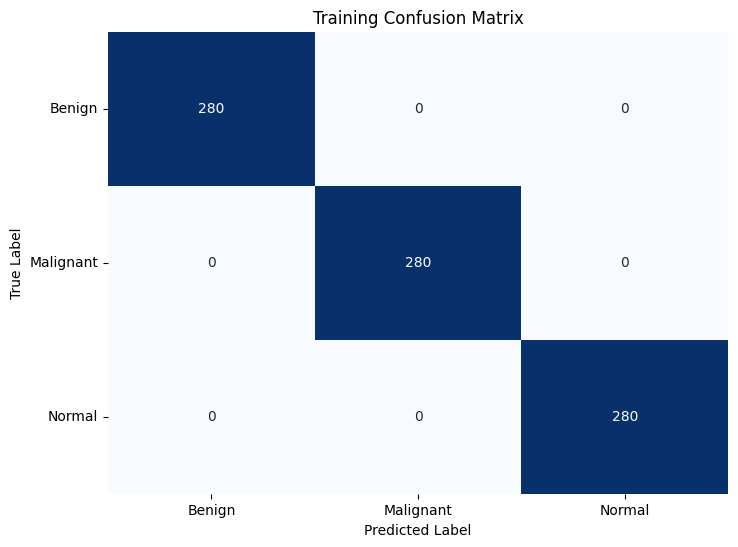

Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


In [70]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
train_dataset_1 = training_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Make predictions on the test dataset
predictions = model.predict(train_dataset_1)

# Extracting classification predictions from the model output
classification_predictions = np.argmax(predictions[0], axis=1)

# Extracting true labels from the test dataset
true_labels = dftrain['severity_encoded'].values

# Map numeric labels to class names
class_names = {
    0: "Benign",
    1: "Malignant",
    2: "Normal"
}

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, classification_predictions)

accuracy = accuracy_score(true_labels, classification_predictions)
f1 = f1_score(true_labels, classification_predictions, average='weighted')

# Calculate precision
precision = precision_score(true_labels, classification_predictions, average='weighted')

# Calculate recall
recall = recall_score(true_labels, classification_predictions, average='weighted')


# Plot the confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)

# Set labels and title
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Training Confusion Matrix')

# Set ticks
tick_labels = [class_names[i] for i in range(len(class_names))]
plt.xticks(np.arange(len(class_names)) + 0.5, tick_labels)
plt.yticks(np.arange(len(class_names)) + 0.5, tick_labels, rotation=0)

plt.show()


# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)



23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


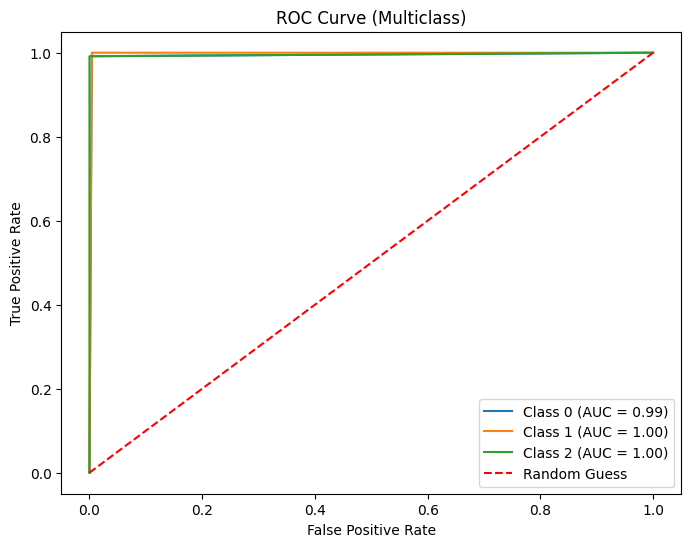

In [71]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelBinarizer


predictions = model.predict(test_dataset)
classification_predictions = np.argmax(predictions[0], axis=1)
true_labels = dftest['severity_encoded'].values

label_binarizer = LabelBinarizer()
y_true_binary = label_binarizer.fit_transform(true_labels)
y_pred_binary = label_binarizer.fit_transform(classification_predictions)
n_classes = y_true_binary.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = roc_auc_score(y_true_binary[:, i], y_pred_binary[:, i])

# Plot ROC AUC scores for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass)')
plt.legend()
plt.show()